# Evolutionary computing
## Assignment III

### Table of Contents
* [Statement](##Statement)
    * [Libraries](###Libraries)
    * [3D surface](###3D_surface)
    * [Parameters](###Parameters)
* [Functions](##Functions)
    * [Binary representation](###Binary_representation)
    * [Real representation](###Real_representation)
    * [Common](###Common)
* [Executive](##Executive)
    * [Binary representation](###Binary_executive)
    * [Real representation](###Real_executive)
* [Results](##Results)
    * [Statistics](###Statistics)
    * [Convergence](###Convergence)
    * [Numerical results](###Numerical_results)

## Statement

### Libraries

In [24]:
from matplotlib import pyplot as plt
plt.style.use('seaborn-whitegrid') 
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import pandas as pd

from numba import jit, cuda 
from scipy.stats import ranksums
import numpy as np
import random

from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

import logging;
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)
logging.disable(logging.WARNING)

### 3D_surface

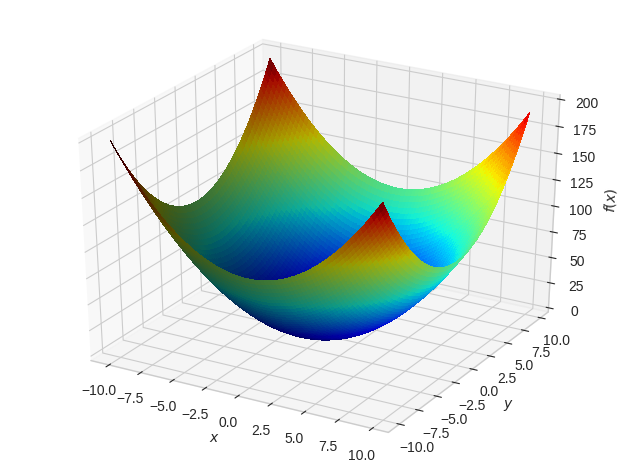

In [2]:
fig = plt.figure()
ax = fig.gca(projection='3d')

X=np.arange(-10,10,0.25)
Y=np.arange(-10,10,0.25)
X,Y = np.meshgrid(X,Y)
Z = X**2 + Y**2

my_col = cm.jet(Z/np.amax(Z))

surf = ax.plot_surface(X,Y,Z,linewidth=0,antialiased=False, rstride=1, cstride=1, facecolors = my_col)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_zlabel(r'$f(x)$')
fig.tight_layout()

plt.show()

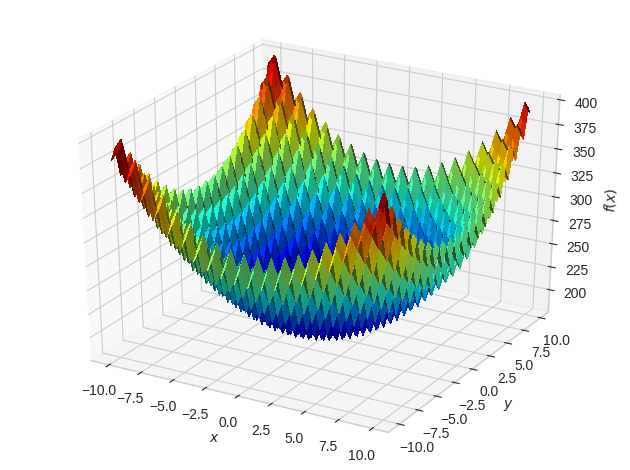

In [3]:
fig = plt.figure()
ax = fig.gca(projection='3d')

X=np.arange(-10,10,0.25)
Y=np.arange(-10,10,0.25)
X,Y = np.meshgrid(X,Y)
Z = 10*10 + X**2 - 10*np.cos(2*np.pi*X) + 10*10 + Y**2 - 10*np.cos(2*np.pi*Y)

surf = ax.plot_surface(X,Y,Z,linewidth=0,antialiased=False, rstride=1, cstride=1, facecolors = my_col)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_zlabel(r'$f(x)$')
fig.tight_layout()
plt.show()

### Parameters

In [4]:
'''Parámetros de entrada
'''
ppl_size = 50 #int(input("Tamaño de la población: "))
generations = 1000 #int(input("Número de generaciones: "))
p_crossover = 0.85 #float(input("Porcentaje de cruza: "))
p_mutation = 0.25 #float(input("Porcentaje de mutación: "))

max_evals = ppl_size*generations

## Functions

### Binary_representation

In [5]:
@jit(target_backend='cuda')
def generateBinarySolution(case):
    if (case == 1):
        return np.random.randint(2, size=10*15)
    if (case == 2):
        return np.random.randint(2, size=10*14)

def deterministicSampling(population, apptitudes, no_parents):
    integers = []
    decimals = []
    net_fit = np.array(apptitudes).sum(axis=0)[1]
    for fit_i in apptitudes:
        expected = (fit_i[1]/net_fit)*len(population)
        i, d = divmod(expected, 1)
        decimals.append((fit_i[0],d))
        if (i == 1.0):
            integers.append(fit_i[0])
    decimals = sorted(decimals,key=lambda l:l[1], reverse=True)
    parents = []
    # Si hay suficientes 1 usarlos
    if (len(integers) >= no_parents):
        for cc in range(no_parents):
            indx = integers[cc]
            parents.append(population[indx])
    # Si no hay suficientes usar los que existan
    elif (len(integers) > 0 and len(integers) < no_parents):
        for dd in integers:
            parents.append(population[dd])
    kk = 0
    # Si faltan padres tomar de los decimales
    while (len(parents) < no_parents):
        parents.append(population[decimals[kk][0]])
        kk += 1
    return parents

@jit(target_backend='cuda')
def binaryCrossover(solution1, solution2):    
    cross_pt = random.randint(1, solution1.size-1)
    first_half1  = solution1[:cross_pt]
    second_half1 = solution1[cross_pt:]
    first_half2  = solution2[:cross_pt]
    second_half2 = solution2[cross_pt:]
    sol_1 = np.concatenate((first_half1,second_half2))
    sol_2 = np.concatenate((first_half2,second_half1))
    return sol_1, sol_2

@jit(target_backend='cuda')
def binaryMutation(solution):
    index = random.randint(1, solution.size-1)
    if (solution[index] == 0):
        solution[index] = 1
    else:
        solution[index] = 0
    return solution

### Real_representation

In [6]:
@jit(target_backend='cuda')
def generateRealSolution(case):
    if (case == 1):
        sol_1 = np.random.uniform(-10,10,10)
        return np.round(sol_1, decimals=3)
    if (case == 2):
        sol_2 = np.random.uniform(-5.12,5.12,10)
        return np.round(sol_2, decimals=3)

def deterministicTournament(population, apptitudes):
    indx_lst = random.sample(range(0, ppl_size), 4)
    parents_subset = []
    for indx in indx_lst:
        parents_subset.append(apptitudes[indx])
    parents_subset.sort(key=lambda a: a[1])
    index_1 = parents_subset[0][0]
    index_2 = parents_subset[1][0]
    parent_1 = population[index_1]
    parent_2 = population[index_2]
    return parent_1, parent_2

@jit(target_backend='cuda')
def realCrossover(good_solution,bad_solution,alpha,beta):
    H = []
    k = len(good_solution)
    for i in range(0, k):
        I = abs(good_solution[i] - bad_solution[i])
        if (good_solution[i] < bad_solution[i]):
            Li = good_solution[i] - alpha*I
            Ls = bad_solution[i] + beta*I
        else:
            Li = bad_solution[i] - beta*I
            Ls = good_solution[i] + alpha*I
        h_i = np.random.uniform(Li,Ls)
        H.append(h_i)
    son = np.array(H)
    return np.round(son, decimals=3)

@jit(target_backend='cuda')
def realMutation(solution, case):
    if (case ==1):
        Linf = -10
        Lsup = 10
    if (case ==2):
        Linf = -5.12
        Lsup = 5.12
    index = random.randint(1, solution.size-1)
    solution[index] = np.random.uniform(Linf,Lsup,1)[0]
    return np.round(solution, decimals=3)

### Common

In [7]:
@jit(target_backend='cuda')
def decodeBin2Real(binSolution, case):
    if (case ==1):
        Linf = -10
        Lsup = 10
        L = 15
    if (case ==2):
        Linf = -5.12
        Lsup = 5.12
        L = 14
    RealSolution = []
    d_splits = np.split(binSolution, 10)
    for split_indx in range(10):
        x = d_splits[split_indx]
        x_integer = 0
        for local_indx in range(L):
            if (x[local_indx] ==1):
                x_integer += 2**(L-1-local_indx)
        x_real = Linf + (x_integer*(Lsup - Linf))/(2**L - 1)
        RealSolution.append(x_real)
    return np.array(RealSolution)

@jit(target_backend='cuda')
def fitness(x, case, isBin = False):
    if (isBin == True):
        x = decodeBin2Real(x,case)  
    if (case == 1):
        fit = np.sum(x**2)
    if (case == 2):
        fit = 10*10 + np.sum(x**2 - 10*np.cos(2*np.pi*x)) 
    return np.round(fit, decimals=3)

@jit(target_backend='cuda')
def generatePopulation(size, case, isBin):
    population = []
    apptitudes = []
    for index in range (0,size):
        if (isBin == True):
            solution = generateBinarySolution(case)
        else:
            solution = generateRealSolution(case)
            solution = np.round(solution, decimals=3)
        apptitude = fitness(solution,case,isBin)
        apptitudes.append((index,apptitude))
        population.append(solution)
    return population, apptitudes

## Executive

### Binary_executive

In [8]:
def executeBinaryRepresentation(c, printScore):
    bestApptitude = []
    averageApptitude = []
    best_solution = 0
    population, apptitudes = generatePopulation(ppl_size,case=c,isBin=True)
    evals = 0
    gens = 0
    while (evals < max_evals):
        no_parents = 10
        midle_indx = int(no_parents/2)
        parents = deterministicSampling(population, apptitudes, no_parents)
        sons_a = []
        sons_b = []
        pc = np.random.uniform(0,1,1)[0]
        if (pc <= p_crossover):
            for i in range(midle_indx):
                son_a, son_b = binaryCrossover(parents[i], parents[midle_indx+i])                
                sons_a.append(son_a)
                sons_b.append(son_b)
        else:
            for i in range(midle_indx):
                sons_a.append(parents[i])
                sons_b.append(parents[midle_indx+i])

        pm = np.random.uniform(0,1,1)[0]
        if (pm <= p_mutation):
            for i in range(midle_indx):
                sons_a[i] = binaryMutation(sons_a[i])
                sons_b[i] = binaryMutation(sons_b[i])

        for i in range(midle_indx):
            population.append(sons_a[i])
            population.append(sons_b[i])

        nuevas_aptitudes = []
        for index in range (0,len(population)):
            apptitude = fitness(population[index],case=c,isBin=True)
            nuevas_aptitudes.append((index,apptitude))

        nuevas_aptitudes.sort(key=lambda a: a[1])

        nueva_poblacion = []
        for i in nuevas_aptitudes:
            nueva_poblacion.append(population[i[0]])

        nuevas_aptitudes.clear()
        nueva_poblacion = nueva_poblacion[:ppl_size]     
        average_fit = 0
        for i in range(0,len(nueva_poblacion)):
            apptitude = fitness(nueva_poblacion[i],case=c,isBin=True)
            average_fit += apptitude
            nuevas_aptitudes.append((i,apptitude))
            evals += 1
        population = nueva_poblacion
        apptitudes = nuevas_aptitudes
        average_fit = average_fit/ppl_size
        bestApptitude.append(apptitudes[0][1])
        averageApptitude.append(average_fit)
        son_decoded = decodeBin2Real(population[apptitudes[0][0]],c) 
        if (evals % ppl_size == 0):
            gens += 1
            if (printScore == True):
                print(son_decoded, "f(x)", apptitudes[0][1], "Gen", gens)
    return bestApptitude, averageApptitude, son_decoded

In [9]:
bbest_appt_1, avg_appt_1, bbest_son_1 = executeBinaryRepresentation(1, True)

/tmp/ipykernel_7119/1656804909.py:39: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "generateBinarySolution" failed type inference due to: No implementation of function Function(<built-in method randint of numpy.random.mtrand.RandomState object at 0x7f3aaf87ec40>) found for signature:
 
 >>> randint(Literal[int](2), size=Literal[int](150))
 
There are 6 candidate implementations:
   - Of which 2 did not match due to:
   Overload in function 'np_randint_impl_1': File: numba/cpython/randomimpl.py: Line 568.
     With argument(s): '(int64, size=int64)':
    Rejected as the implementation raised a specific error:
      TypingError: got an unexpected keyword argument 'size'
  raised from /home/jhermosilla/.local/lib/python3.8/site-packages/numba/core/typing/templates.py:784
   - Of which 4 did not match due to:
   Overload in function 'np_randint_impl_2': File: numba/cpython/randomimpl.py: Line 574.
     With argument(s): '(int64, size=i

[-0.05951109 -5.28977325 -7.59086886  0.67903684 -2.10913419 -2.34717856
  5.21164586  1.97607349  2.735374    6.9450972 ] f(x) 182.808 Gen 1
[-0.05951109 -5.28977325 -7.59086886  0.67903684 -2.10913419 -2.34717856
  5.21164586  1.97607349  2.735374    6.9450972 ] f(x) 182.808 Gen 2
[-0.05951109 -5.28977325 -7.59086886  0.67903684 -2.10913419 -2.34717856
  5.21164586  1.97607349  2.735374    6.9450972 ] f(x) 182.808 Gen 3
[-0.05951109 -5.28977325 -7.59086886  0.67903684 -2.10913419 -2.34717856
  5.21164586  1.97607349  2.735374    6.9450972 ] f(x) 182.808 Gen 4
[-0.05951109 -5.28977325 -7.59086886  0.67903684 -2.10913419 -2.34717856
  5.21164586  1.97607349  2.735374    6.9450972 ] f(x) 182.808 Gen 5
[-0.05951109 -5.28977325 -7.59086886  0.67903684 -2.10913419 -2.34717856
  5.21164586  1.97607349  2.735374    6.9450972 ] f(x) 182.808 Gen 6
[-0.05951109 -5.28977325 -7.59086886  0.67903684 -2.10913419 -2.34717856
  5.21164586  1.97607349  2.735374    6.9450972 ] f(x) 182.808 Gen 7
[-1.60

In [10]:
bbest_appt_2, avg_appt_2, bbest_son_2 = executeBinaryRepresentation(2, True)

[ 0.88599158  0.65160227  3.16175548 -4.82810718  1.89917842  2.07106391
 -0.82036257  3.04424831  1.93855582  2.08356467] f(x) 99.838 Gen 1
[ 0.88599158  0.65160227  3.16175548 -4.82810718  1.89917842  2.07106391
 -0.82036257  3.04424831  1.93855582  2.08356467] f(x) 99.838 Gen 2
[ 0.88599158  0.65160227  3.16175548 -4.82810718  1.89917842  2.07106391
 -0.82036257  3.04424831  1.93855582  2.08356467] f(x) 99.838 Gen 3
[ 0.88599158  0.65160227  3.16175548 -4.82810718  1.89917842  2.07106391
 -0.82036257  3.04424831  1.93855582  2.08356467] f(x) 99.838 Gen 4
[ 0.88599158  0.65160227  3.16175548 -4.82810718  1.89917842  2.07106391
 -0.82036257  3.04424831  1.93855582  2.08356467] f(x) 99.838 Gen 5
[ 0.88599158  0.65160227  3.16175548 -4.82810718  1.89917842  2.07106391
 -0.82036257  3.04424831  1.93855582  2.08356467] f(x) 99.838 Gen 6
[ 0.88599158  0.65160227  3.16175548 -4.82810718  1.89917842  2.07106391
 -0.82036257  3.04424831  1.93855582  2.08356467] f(x) 99.838 Gen 7
[ 0.88599158 

### Real_executive

In [11]:
def executeRealRepresentation(c, printScore):
    bestApptitude = []
    averageApptitude = []
    best_solution = 0
    population, apptitudes = generatePopulation(ppl_size,case=c,isBin=False)
    evals = 0
    gens = 0
    while (evals < max_evals):
        parent_1, parent_2 = deterministicTournament(population, apptitudes)
        fit_1 = fitness(parent_1,case=c,isBin=False)
        fit_2 = fitness(parent_2,case=c,isBin=False)
        if (fit_1 < fit_2):
            son_1 = realCrossover(parent_1, parent_2, 0.5, 0.5)
            son_2 = realCrossover(parent_1, parent_2, 0.5, 0.5)
        else: 
            son_1 = realCrossover(parent_2, parent_1, 0.5, 0.5)
            son_2 = realCrossover(parent_2, parent_1, 0.5, 0.5)

        pm = np.random.uniform(0,1,1)[0]
        if (pm <= p_mutation):
            son_1 = realMutation(son_1,c)
            son_2 = realMutation(son_2,c)
        else:
            son_1, son_2 = parent_1, parent_2

        population.append(son_1)
        population.append(son_2)

        nuevas_aptitudes = []
        for index in range (0,len(population)):
            apptitude = fitness(population[index],case=c,isBin=False)
            nuevas_aptitudes.append((index,apptitude))

        nuevas_aptitudes.sort(key=lambda a: a[1])

        nueva_poblacion = []
        for i in nuevas_aptitudes:
            nueva_poblacion.append(population[i[0]])

        nuevas_aptitudes.clear()
        nueva_poblacion = nueva_poblacion[:ppl_size]     
        average_fit = 0
        for i in range(0,len(nueva_poblacion)):
            apptitude = fitness(nueva_poblacion[i],case=c,isBin=False)
            average_fit += apptitude
            nuevas_aptitudes.append((i,apptitude))
            evals += 1
        population = nueva_poblacion
        apptitudes = nuevas_aptitudes
        average_fit = average_fit/ppl_size
        bestApptitude.append(apptitudes[0][1])
        averageApptitude.append(average_fit)
        if (evals % ppl_size == 0):
            gens += 1
            if (printScore == True):
                print(population[apptitudes[0][0]], "f(x)", apptitudes[0][1], "Gen", gens)
    return bestApptitude, averageApptitude, population[apptitudes[0][0]]

In [12]:
bbest_appt_3, avg_appt_3, bbest_son_3 = executeRealRepresentation(1, True)

[ 1.533e+00  2.697e+00 -4.589e+00 -3.647e+00  2.614e+00 -7.110e-01
  5.000e-03  1.746e+00  4.285e+00  8.022e+00] f(x) 137.084 Gen 1
[ 1.533e+00  2.697e+00 -4.589e+00 -3.647e+00  2.614e+00 -7.110e-01
  5.000e-03  1.746e+00  4.285e+00  8.022e+00] f(x) 137.084 Gen 2
[ 1.533e+00  2.697e+00 -4.589e+00 -3.647e+00  2.614e+00 -7.110e-01
  5.000e-03  1.746e+00  4.285e+00  8.022e+00] f(x) 137.084 Gen 3
[ 1.533e+00  2.697e+00 -4.589e+00 -3.647e+00  2.614e+00 -7.110e-01
  5.000e-03  1.746e+00  4.285e+00  8.022e+00] f(x) 137.084 Gen 4
[ 1.533e+00  2.697e+00 -4.589e+00 -3.647e+00  2.614e+00 -7.110e-01
  5.000e-03  1.746e+00  4.285e+00  8.022e+00] f(x) 137.084 Gen 5
[ 1.533e+00  2.697e+00 -4.589e+00 -3.647e+00  2.614e+00 -7.110e-01
  5.000e-03  1.746e+00  4.285e+00  8.022e+00] f(x) 137.084 Gen 6
[ 1.533e+00  2.697e+00 -4.589e+00 -3.647e+00  2.614e+00 -7.110e-01
  5.000e-03  1.746e+00  4.285e+00  8.022e+00] f(x) 137.084 Gen 7
[ 1.533e+00  2.697e+00 -4.589e+00 -3.647e+00  2.614e+00 -7.110e-01
  5.000e-

In [13]:
bbest_appt_4, avg_appt_4, bbest_son_4 = executeRealRepresentation(2, True)

[ 1.033  0.408  2.628  1.088 -0.408 -2.347 -0.926 -0.866  3.023 -3.703] f(x) 127.988 Gen 1
[ 1.033  0.408  2.628  1.088 -0.408 -2.347 -0.926 -0.866  3.023 -3.703] f(x) 127.988 Gen 2
[ 1.033  0.408  2.628  1.088 -0.408 -2.347 -0.926 -0.866  3.023 -3.703] f(x) 127.988 Gen 3
[ 1.033  0.408  2.628  1.088 -0.408 -2.347 -0.926 -0.866  3.023 -3.703] f(x) 127.988 Gen 4
[ 1.033  0.408  2.628  1.088 -0.408 -2.347 -0.926 -0.866  3.023 -3.703] f(x) 127.988 Gen 5
[ 1.033  0.408  2.628  1.088 -0.408 -2.347 -0.926 -0.866  3.023 -3.703] f(x) 127.988 Gen 6
[ 1.033  0.408  2.628  1.088 -0.408 -2.347 -0.926 -0.866  3.023 -3.703] f(x) 127.988 Gen 7
[ 1.033  0.408  2.628  1.088 -0.408 -2.347 -0.926 -0.866  3.023 -3.703] f(x) 127.988 Gen 8
[ 1.033  0.408  2.628  1.088 -0.408 -2.347 -0.926 -0.866  3.023 -3.703] f(x) 127.988 Gen 9
[ 1.033  0.408  2.628  1.088 -0.408 -2.347 -0.926 -0.866  3.023 -3.703] f(x) 127.988 Gen 10
[ 1.033  0.408  2.628  1.088 -0.408 -2.347 -0.926 -0.866  3.023 -3.703] f(x) 127.988 Gen 

## Results

In [14]:
history_1B = []
history_1R = []
history_2B = []
history_2R = []

record_1B = []
record_1R = []
record_2B = []
record_2R = []

sons_1B = []
sons_1R = []
sons_2B = []
sons_2R = []

for i in range(10):
    bbest_appt_1B, _, bbest_son_1B = executeBinaryRepresentation(1, False)
    bbest_appt_1R, _, bbest_son_1R = executeRealRepresentation(1, False)
    bbest_appt_2B, _, bbest_son_2B = executeBinaryRepresentation(2, False)
    bbest_appt_2R, _, bbest_son_2R = executeRealRepresentation(2, False)

    history_1B.append([i,bbest_appt_1B[-1]])
    record_1B.append(bbest_appt_1B)
    sons_1B.append(bbest_son_1B)
    history_1R.append([i,bbest_appt_1R[-1]])
    record_1R.append(bbest_appt_1R)
    sons_1R.append(bbest_son_1R)
    history_2B.append([i,bbest_appt_2B[-1]])
    record_2B.append(bbest_appt_2B)
    sons_2B.append(bbest_son_2B)
    history_2R.append([i,bbest_appt_2R[-1]])
    record_2R.append(bbest_appt_2R)
    sons_2R.append(bbest_son_2R)

### Statistics

In [29]:
history_1R_np = np.array(history_1R)
max_1R = np.max(history_1R_np, axis=0)[1]
min_1R = np.min(history_1R_np, axis=0)[1]

best_1R = history_1R_np[np.where(history_1R_np[:,1] == min_1R)]
worst1R = history_1R_np[np.where(history_1R_np[:,1] == max_1R)]
mean_1R = np.mean(history_1R_np[:,1])
median1R = np.median(history_1R_np[:,1])
std_1R = np.std(history_1R_np[:,1])

history_1B_np = np.array(history_1B)
max_1B = np.max(history_1B_np, axis=0)[1]
min_1B = np.min(history_1B_np, axis=0)[1]

best_1B = history_1B_np[np.where(history_1B_np[:,1] == min_1B)]
worst1B = history_1B_np[np.where(history_1B_np[:,1] == max_1B)]
mean_1B = np.mean(history_1B_np[:,1])
median1B = np.median(history_1B_np[:,1])
std_1B = np.std(history_1B_np[:,1])

problem_1 = {'Binary': pd.Series([best_1B[0,1], worst1B[0,1], mean_1B, median1B, std_1B],
                      index=['best', 'worst', 'mean', 'median', 'sdt']),
            'Real': pd.Series([best_1R[0,1], worst1R[0,1], mean_1R, median1R, std_1R],
                      index=['best', 'worst', 'mean', 'median', 'sdt'])}
 
problem_1_df = pd.DataFrame(problem_1)
print("Problem 1")
print(ranksums(history_1B_np[:,1], history_1R_np[:,1]))
problem_1_df

Problem 1
RanksumsResult(statistic=-3.779644730092272, pvalue=0.00015705228423075119)


,Binary,Real
best,0.001000,0.482000
worst,0.004000,31.546000
mean,0.001700,8.666900
median,0.001000,4.909000
sdt,0.001005,9.279866


In [30]:
history_2R_np = np.array(history_2R)
max_2R = np.max(history_2R_np, axis=0)[1]
min_2R = np.min(history_2R_np, axis=0)[1]

best_2R = history_2R_np[np.where(history_2R_np[:,1] == min_2R)]
worst2R = history_2R_np[np.where(history_2R_np[:,1] == max_2R)]
mean_2R = np.mean(history_2R_np[:,1])
median2R = np.median(history_2R_np[:,1])
std_2R = np.std(history_2R_np[:,1])

history_2B_np = np.array(history_2B)
max_2B = np.max(history_2B_np, axis=0)[1]
min_2B = np.min(history_2B_np, axis=0)[1]

best_2B = history_2B_np[np.where(history_2B_np[:,1] == min_2B)]
worst2B = history_2B_np[np.where(history_2B_np[:,1] == max_2B)]
mean_2B = np.mean(history_2B_np[:,1])
median2B = np.median(history_2B_np[:,1])
std_2B = np.std(history_2B_np[:,1])

problem_2 = {'Binary': pd.Series([best_2B[0,1], worst2B[0,1], mean_2B, median2B, std_2B],
                      index=['best', 'worst', 'mean', 'median', 'sdt']),
            'Real': pd.Series([best_2R[0,1], worst2R[0,1], mean_2R, median2R, std_2R],
                      index=['best', 'worst', 'mean', 'median', 'sdt'])}
 
problem_2_df = pd.DataFrame(problem_2)
print("Problem 2")
print(ranksums(history_2B_np[:,1], history_2R_np[:,1]))
problem_2_df

Problem 2
RanksumsResult(statistic=-3.250494467879354, pvalue=0.0011520450981421845)


,Binary,Real
best,3.486000,8.70200
worst,15.951000,33.94000
mean,8.917900,20.96500
median,8.465500,21.95500
sdt,3.233482,7.02943


In [17]:
indx_median_1B = np.argsort(history_1B_np[:,1])[len(history_1B_np[:,1])//2]
indx_median_1R = np.argsort(history_1R_np[:,1])[len(history_1R_np[:,1])//2]
indx_median_2B = np.argsort(history_2B_np[:,1])[len(history_2B_np[:,1])//2]
indx_median_2R = np.argsort(history_2R_np[:,1])[len(history_2R_np[:,1])//2]

### Convergence

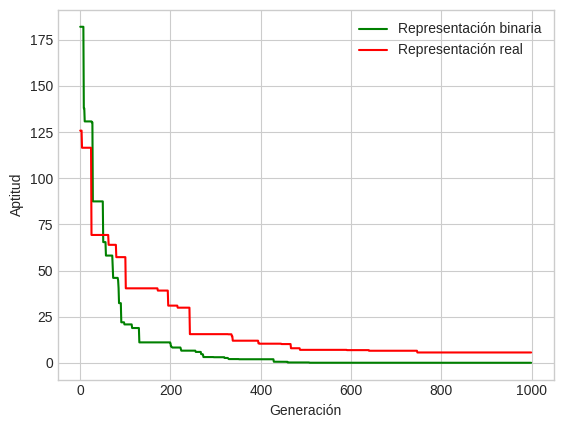

In [18]:
plt.plot(record_1B[indx_median_1B], label='Representación binaria', color='g')
plt.plot(record_1R[indx_median_1R], label='Representación real', color='r')

plt.xlabel("Generación")
plt.ylabel("Aptitud")
plt.legend() 
plt.show()

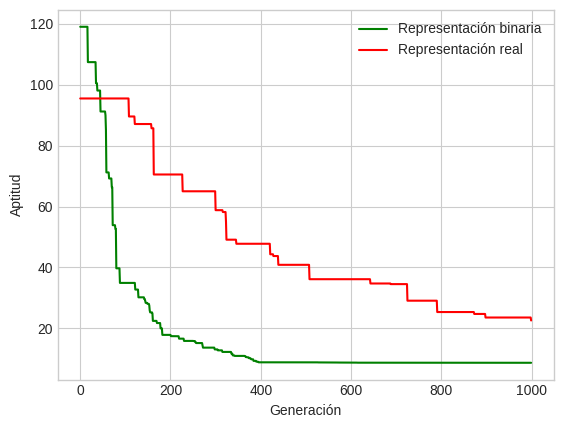

In [19]:
plt.plot(record_2B[indx_median_2B], label='Representación binaria', color='g')
plt.plot(record_2R[indx_median_2R], label='Representación real', color='r')

plt.xlabel("Generación")
plt.ylabel("Aptitud")
plt.legend() 
plt.show()

### Numerical_results

In [20]:
df_1B = pd.DataFrame(np.array(sons_1B))
print(df_1B)
print("Best result at row:", int(best_1B[0,0]))

          0         1         2         3         4         5         6  \
0  0.018006 -0.004578 -0.007630 -0.010071  0.024110 -0.001526  0.008850   
1  0.000305 -0.013733 -0.004578  0.005799 -0.000305  0.009461 -0.002747   
2  0.014954 -0.007019  0.003967 -0.007019 -0.019837  0.000916 -0.028993   
3 -0.017396  0.003967  0.000916  0.000916 -0.005799 -0.024110 -0.007019   
4 -0.011902  0.000916 -0.000305 -0.005799  0.010681  0.017396 -0.009461   
5  0.019227 -0.002747  0.008240 -0.004578 -0.004578  0.000916 -0.008850   
6 -0.001526 -0.008850  0.006409  0.006409 -0.017396 -0.011292 -0.013733   
7 -0.031434 -0.010071 -0.014954  0.000916  0.009461  0.000916 -0.011292   
8 -0.032655 -0.000305 -0.025941 -0.000916 -0.019837  0.003357 -0.026551   
9 -0.003357 -0.005799  0.013733  0.012513 -0.001526 -0.039369  0.000305   

          7         8         9  
0  0.016785  0.000305 -0.004578  
1 -0.002747  0.018616 -0.027161  
2 -0.003357  0.018616  0.008850  
3  0.009461  0.005188  0.000916  
4  0

In [21]:
df_1R = pd.DataFrame(np.array(sons_1R))
print(df_1R)
print("Best result at row:", int(best_1R[0,0]))

       0      1      2      3      4      5      6      7      8      9
0  4.075 -0.112  0.086 -1.575 -0.480  0.059  0.095 -0.357 -0.344 -0.263
1 -1.205 -0.919  0.780  0.241  0.352  0.329 -0.859  0.379 -0.214  0.329
2  2.260  0.221  0.503  0.269 -0.464 -0.194  0.192  0.077  0.035  0.022
3  3.009  0.972  0.287  0.492 -0.291  0.573  0.131  0.575 -0.215 -0.011
4 -0.244  0.738  0.856  0.264  0.081 -0.371  0.001  0.412  0.139  0.361
5  5.379 -0.701  0.179 -0.757  0.532 -0.321 -1.016 -0.075  0.303 -0.002
6 -1.495  0.048 -0.037  0.385  0.201 -0.025 -0.093  0.392  0.490 -0.671
7 -0.965 -0.122  0.356  0.269 -0.068  1.286  0.072 -0.306  0.443 -0.016
8  1.737  0.169 -0.190 -0.679  0.384 -1.272  0.280 -0.286 -0.330 -0.097
9 -0.193 -0.172 -0.008  0.130 -0.023  0.424  0.101 -0.145  0.428 -0.057
Best result at row: 9


In [22]:
df_2B = pd.DataFrame(np.array(sons_2B))
print(df_2B)
print("Best result at row:", int(best_2B[0,0]))

          0         1         2         3         4         5         6  \
0 -0.000938  0.959746 -1.000999 -0.959746  1.000374  0.000313 -0.001563   
1  0.000938 -0.000938  0.000938 -0.005313  0.001563 -1.000374  0.959746   
2 -0.000313  0.959746  0.959121 -1.002874 -0.959746 -0.000313  0.989748   
3 -1.989184 -2.000435  0.001563  0.000938  0.959746 -0.995373  0.000313   
4  1.000374  0.959746  1.006624  0.005313 -1.002249 -0.990998 -0.002188   
5 -0.000313  0.995998 -0.994748  1.991059 -0.000313  0.994123  0.959746   
6 -0.001563  0.994123  1.992309  1.990434 -0.002188 -1.000374  2.000435   
7  0.995373  0.989748 -1.000374 -0.992248 -0.959746  0.959746  0.994123   
8  0.994748 -0.996623 -0.993498 -0.959746  0.000938  0.000313 -0.995373   
9  0.994123  0.995998 -0.959746 -1.989809 -0.000938  0.010313  0.000313   

          7         8         9  
0  1.000374 -0.959746 -0.000313  
1  0.959746  0.000938 -0.000313  
2  0.959746  0.959746  0.000313  
3 -0.000938 -0.000313  0.000313  
4 -0

In [23]:
df_2R = pd.DataFrame(np.array(sons_2R))
print(df_2R)
print("Best result at row:", int(best_2R[0,0]))

       0      1      2      3      4      5      6      7      8      9
0  1.886  1.016 -0.876 -1.004 -0.941 -0.985 -0.113  0.965 -0.029 -0.066
1  2.108 -0.040 -0.963  0.049 -1.043  0.037 -1.959  0.124 -0.077  1.937
2  1.270  0.057  0.040  0.014 -1.013  1.068 -0.982  0.115 -0.954 -0.063
3  1.228  0.928  0.066  0.055  0.042  0.091  0.050 -1.067 -0.947 -1.139
4  1.323 -0.088  0.025 -0.991 -0.962 -0.995 -0.973 -0.126 -1.023  0.102
5 -2.008  0.908 -0.033 -0.108  1.007 -0.043 -0.006 -1.037 -1.009 -1.999
6 -0.019 -0.006  0.096  0.073  0.947 -0.951 -0.003 -0.100  2.006  0.033
7  0.033  0.028 -0.042  0.087 -0.964  0.994  0.072 -0.062 -0.096  0.064
8  0.105  0.889  1.123 -1.053  0.030  1.058  0.016  0.897 -0.948 -1.122
9 -3.165  0.895 -0.069 -0.046 -0.020 -1.071 -1.016 -0.827  1.037 -1.965
Best result at row: 7
